# MAIS202 Assignment 4 Group 1

![To make your day better :)](https://media.gettyimages.com/videos/close-up-baboon-making-noise-on-telephone-video-id712-17?s=640x640)


Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Importing Kagle Data

In [3]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 3.4MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=5ac3975ba2bce08c83ed7f2b5186c53e89c9733685cb33ac87080fb90390e824
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [4]:
from google.colab import files

files.upload() #upload kaggle API
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [5]:
!kaggle competitions download -c mais-202-winter-2021-kaggle-comp

 98% 961M/980M [00:37<00:01, 19.5MB/s]
100% 980M/980M [00:37<00:00, 27.5MB/s]


In [6]:
!unzip mais-202-winter-2021-kaggle-comp.zip

Archive:  mais-202-winter-2021-kaggle-comp.zip
  inflating: test_x.npy              
  inflating: train_x.npy             
  inflating: train_y.csv             


In [7]:
import numpy as np

In [8]:
train_images = np.load("train_x.npy", allow_pickle=True)
train_images_true_label = np.genfromtxt("train_y.csv",delimiter=",",names=True)
test_images = np.load("test_x.npy", allow_pickle=True)

print("Header Names", train_images_true_label.dtype.names)
print(train_images_true_label)
print(len(train_images))
len(test_images)

Header Names ('ID', 'Label')
[(0.0000e+00, 6.) (1.0000e+00, 7.) (2.0000e+00, 2.) ... (3.9997e+04, 9.)
 (3.9998e+04, 8.) (3.9999e+04, 8.)]
40000


10000

### Plotting a few images to visualize

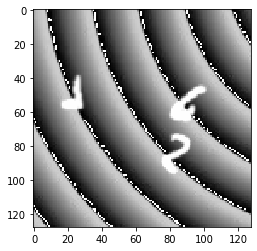

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_image(arr):
    two_d = (np.reshape(arr, (128, 128)) * 255).astype(np.uint8)
    plt.imshow(two_d,interpolation='nearest',cmap="Greys")
    plt.show()

show_image(train_images[0]) # 0 is the index of the training image you want to display

## 2. Creating Our CNN Model

In [10]:
#Importing everything we need
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.preprocessing import image
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D, GaussianNoise
from keras import regularizers, optimizers
from keras.optimizers import Adam

In [11]:
IMG_SIZE = 128

#Normalizing and reshaping our images
def normalize_reshape(imgs,height=IMG_SIZE,width=IMG_SIZE,channels=1):
    imgs = 1-imgs/255.0 #normalizing and inverting the image
    n=len(imgs)
    return imgs.reshape(n,height,width,channels)

train_images = normalize_reshape(train_images)
test_images = normalize_reshape(test_images)
print("Train Images Shape =",train_images.shape)

#Selecting the y_train column
y_train = train_images_true_label["Label"]

Train Images Shape = (40000, 128, 128, 1)


In [35]:
#Define our model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(96, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(96, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(9e-4)))
model.add(Dropout(0.5)) #to reduce overfitting

model.add(Dense(10, activation='softmax')) #since we have 10 classes

model.compile(optimizer=Adam(lr=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 28, 28, 96)        55392     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 14, 14, 96)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 12, 12, 96)       

## 3. Training Our Model

In [36]:
#Creating our checkpoints
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=3,
                                  verbose=1, factor=0.2, min_lr=1e-7)

filepath="model.h5"
checkpoint_diagnosis = ModelCheckpoint(filepath, monitor='val_accuracy', 
                                       verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor="val_accuracy", patience=4,
                               min_delta=0, verbose=1, mode="auto")

trained_model = model.fit(x=train_images,
                        y=y_train,
                        epochs=40,
                        validation_split=0.2,
                        callbacks=[learn_control, checkpoint_diagnosis, early_stopping],
                        shuffle=True,
                        batch_size=32,
                        verbose=1)

Epoch 1/40
1000/1000 [==============================] - 11s 11ms/step - loss: 1.9749 - accuracy: 0.2494 - val_loss: 1.6325 - val_accuracy: 0.3679

Epoch 00001: val_accuracy improved from -inf to 0.36788, saving model to model.h5
Epoch 2/40
1000/1000 [==============================] - 11s 11ms/step - loss: 1.4817 - accuracy: 0.4520 - val_loss: 1.0160 - val_accuracy: 0.7004

Epoch 00002: val_accuracy improved from 0.36788 to 0.70038, saving model to model.h5
Epoch 3/40
1000/1000 [==============================] - 11s 11ms/step - loss: 0.9465 - accuracy: 0.7078 - val_loss: 0.7238 - val_accuracy: 0.7855

Epoch 00003: val_accuracy improved from 0.70038 to 0.78550, saving model to model.h5
Epoch 4/40
1000/1000 [==============================] - 11s 11ms/step - loss: 0.7912 - accuracy: 0.7552 - val_loss: 0.6114 - val_accuracy: 0.8204

Epoch 00004: val_accuracy improved from 0.78550 to 0.82038, saving model to model.h5
Epoch 5/40
1000/1000 [==============================] - 11s 11ms/step - los

Copy model to google drive for saving

In [ ]:
!export savedir='/content/drive/MyDrive/MAIS202Assignment4SavedModel'; echo $savedir; if [[ ! -d $savedir ]]; then mkdir $savedir; fi; cp model.h5 $savedir/model.h5

/content/drive/MyDrive/MAIS202Assignment4SavedModel


## 4. Evaluating Our Model 

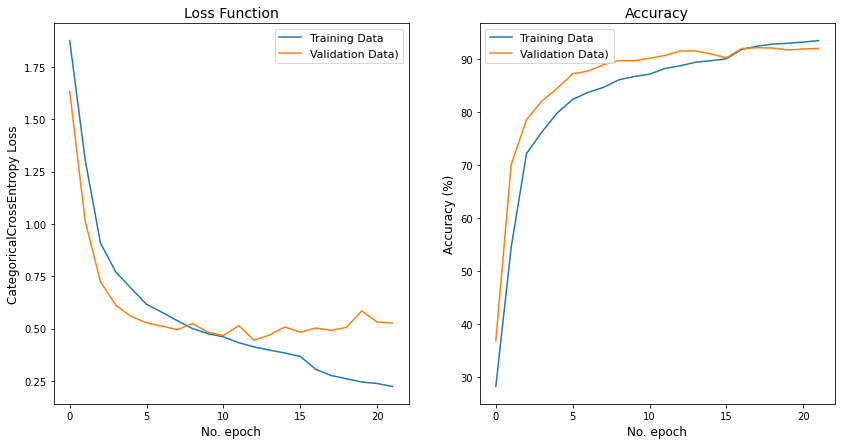

In [37]:
#Creating plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))

ax1.plot(trained_model.history['loss'], label='Training Data')
ax1.plot(trained_model.history['val_loss'], label='Validation Data)')
ax1.set_title('Loss Function', fontsize=14)
ax1.set_ylabel('CategoricalCrossEntropy Loss', fontsize=12)
ax1.set_xlabel('No. epoch', fontsize=12)
ax1.legend(loc="upper right", fontsize=11)

ax2.plot([100*i for i in trained_model.history['accuracy']], label='Training Data')
ax2.plot([100*i for i in trained_model.history['val_accuracy']], label='Validation Data)')
ax2.set_title('Accuracy', fontsize=14)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_xlabel('No. epoch', fontsize=12)
ax2.legend(loc="upper left", fontsize=11)
#plt.savefig("evaluation.png",bbox_inches="tight",dpi=200)

plt.show()

In [38]:
#Defining a function to plot our confusion matrix (taken from the source below)
import itertools
def confusion_matrix_plot(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig("Confusion_Matrix.png",bbox_inches="tight",dpi=200)
    plt.show()

Confusion Matrix


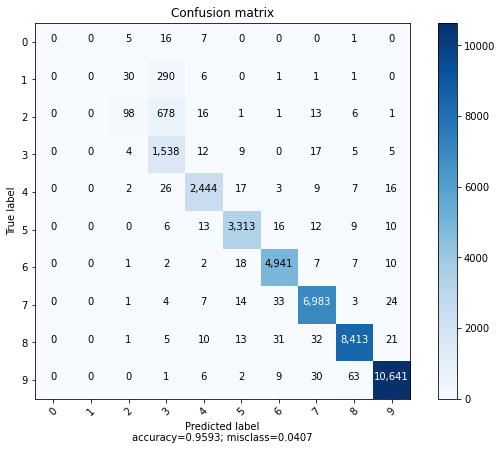

In [39]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

#Creating our confusion matrix
Y_pred = model.predict(train_images)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
conf = confusion_matrix(y_train,y_pred)

#Plotting confusion matrix
confusion_matrix_plot(conf,target_names=np.arange(0,10),normalize=False)

## 5. Applying the Model to the Test Set

Prediction = 9


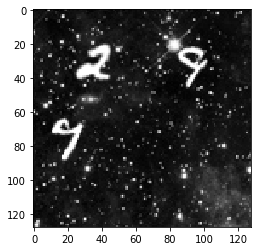

In [40]:
#Finding the predictions for the entire test set
test_prediction = model.predict(test_images)
test_prediction = [np.argmax(pred) for pred in test_prediction]

#Just a test on one image
image_number = 2
print("Prediction =", test_prediction[image_number])
show_image(test_images[image_number])

In [27]:
#Making the submission .csv file
import csv

with open('submission_group_1.csv', 'w') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    filewriter.writerow(['ID', 'Category'])
    for idx, pred in enumerate(test_prediction):
        filewriter.writerow([idx, pred])


In [28]:
#To submit the .csv file to kaggle
!kaggle competitions submit -c mais-202-winter-2021-kaggle-comp -f submission_group_1.csv -m "Submission for group 1 (Hongjun, Jehan, Miiyu)"

100% 77.1k/77.1k [00:10<00:00, 7.72kB/s]
Successfully submitted to MAIS 202 Winter 2021 - Assignment 4